In [10]:
import numpy as np
import torch

from src.agent.agent import PPOAgent
from src.env import MarketEnv
from src.agent.replay_buffer import ReplayBuffer


In [2]:
def config_reshape(action, size, low, high):
    action = low + (high - low) * action / size
    action = np.clip(action, low, high)
    return action

In [3]:
env = MarketEnv(spread_mean=250)
precision = int(1e3)
action_reshape = lambda action: config_reshape(action, precision, env.action_space.low, env.action_space.high / 1000)
state_dim = env.observation_space.shape[0]
action_dim = [int(precision) for _ in range(env.action_space.shape[0])]
agent = PPOAgent(
    state_dim=state_dim,
    action_dim=action_dim,
    policy_hidden_dims=(state_dim * 5, state_dim * 10, state_dim * 10),
    value_hidden_dims=(state_dim * 10, state_dim, int(np.sqrt(state_dim))),
    action_reshape=action_reshape,
    lr=1e-3,
    gamma=0.99,
    eps_clip=0.2,
    gae_lambda=0.99,
    entropy_coef=0.02
)

In [7]:
trajectories = ReplayBuffer()
state, _ = env.reset()

In [11]:
action, log_prob, _ = agent.policy_network.act(torch.tensor(state, dtype=torch.float32).cuda().unsqueeze(0))
next_state, reward, done, trunc, _ = env.step(agent.action_reshape(agent.policy_network.get_action(action)))
done = done or trunc
trajectories.add(state, action, log_prob, reward, done)
state = next_state

In [13]:
env.simulator.user_variables

{'bid_price': 99.9966,
 'ask_price': 100.11240000000001,
 'bid_quantity': 0.0441,
 'ask_quantity': 0.08710000000000001,
 'ask_order': <env.lob.limit_order_book.Order at 0x7f8229959290>,
 'bid_order': <env.lob.limit_order_book.Order at 0x7f822a06e3d0>,
 'cash': 0,
 'inventory': 0}

In [23]:
print(env.simulator.lob.orders[env.simulator.user_variables['bid_order'].uuid].price)
print(env.simulator.lob.orders[env.simulator.user_variables['ask_order'].uuid].price)

100.0
100.11


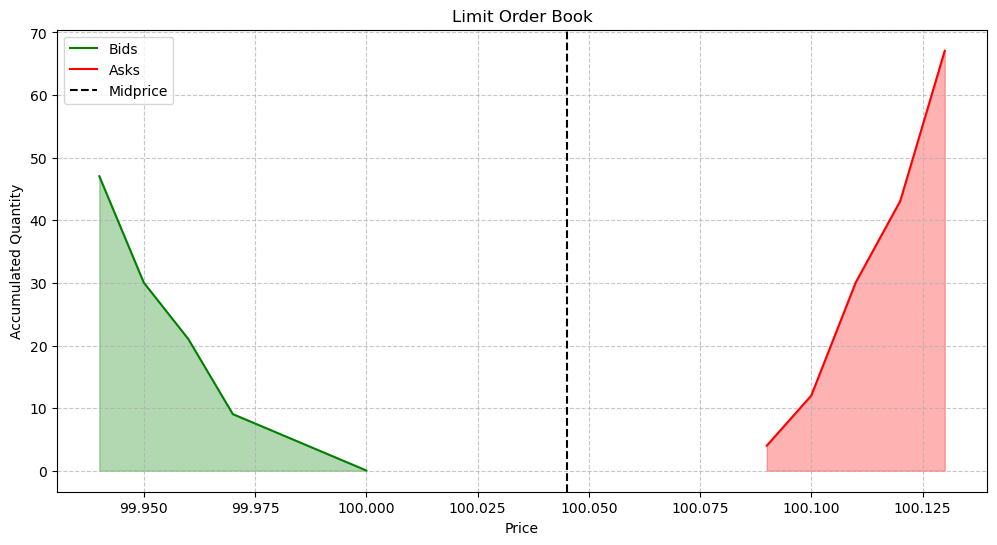

In [12]:
env.simulator.lob.plot()

In [28]:
action_new, log_prob_new, _ = agent.policy_network.act(torch.tensor(state, dtype=torch.float32).cuda().unsqueeze(0))
action_new = agent.action_reshape(agent.policy_network.get_action(action_new))

print(round(env.simulator.midprice() - action_new[0], env.simulator.tick_size))
print(round(env.simulator.midprice() + action_new[2], env.simulator.tick_size))

100.0
100.08


In [31]:
next_state, reward, done, trunc, _ = env.step(None)

KeyboardInterrupt: 